In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLMResultsWrapper

# plt.style.use('dark_background')
random_state=42
YLIM = (120, 135)

PARAMS_MAPPING = {
    "Intercept": "$intercepto$",
    "Sexo": "$sexo_i$",
    "Edad": "$edad_i$",
    "Mes": "$mes_j$",
    "Adherencia": "$adherencia_{ij}$",
    "Mes*Adherencia": "$mes_j\ adherencia_{ij}$",
    "Adherencia_Perfecta": "$adherencia\ perfecta_i$",
    "Mes*Adherencia_Perfecta": "$mes_j\ adherencia\ perfecta_i$",
    "Adherencia_Total": "$\overline{adherencia}_i$",
    "Mes*Adherencia_Total": "$mes_j\ \overline{adherencia}_i$",
    "Adherencia_lag1": "$adherencia_{ij-1}$",
    "Mes*Adherencia_lag1": "$mes_j\ adherencia_{ij-1}$",
    "Adherencia_Acumulada": "$\overline{adherencia}_{ij}$",
    "Mes*Adherencia_Acumulada": "$mes_j\ \overline{adherencia}_{ij}$",
}

In [2]:
def add_minor_if_zero(num):
    return num if num != "0.0" else "<0.001"

In [3]:
def model_to_latex(model: MixedLMResultsWrapper) -> str:
    fe_params = model.fe_params.round(3)
    bse_fe = model.bse_fe.round(3)
    tvalues = model.tvalues.round(3)
    pvalues = "$" + model.pvalues.round(3).astype(str).apply(add_minor_if_zero) + "$"
    table = ""
    for name in fe_params.index:
        table += f"\n\t    {PARAMS_MAPPING[name]} & {fe_params[name]} & {bse_fe[name]} & {tvalues[name]} & ".replace(".", ",") + f"{pvalues[name]} \\\\"
    return fr"""
    \begin{{tabular}}{{*{{5}}{{|c}}|}}
        \hline
        \multicolumn{{3}}{{|c}}{{Log-Likelihood}} & \multicolumn{{2}}{{|c|}}{{{round(model.llf, 2)}}} \\
        \multicolumn{{3}}{{|c}}{{AIC}} & \multicolumn{{2}}{{|c|}}{{{round(model.aic, 2)}}} \\
        \multicolumn{{3}}{{|c}}{{BIC}} & \multicolumn{{2}}{{|c|}}{{{round(model.bic, 2)}}} \\
        \hline
        Covariable				   & Coef.                         & Std. Err.                  & z                           & $P<|z|$  \\
        \hline{table}
        \hline
    \end{{tabular}}
"""

In [4]:
tesis = pd.read_csv("../Datos/tesis_final_preprocesado.csv")
tesis.head()

,idPaciente,Mes,TAS,Adherencia,Sexo,Edad,tas_basal,Adherencia_Acumulada,Adherencia_Total,Adherencia_Perfecta,...,Intercept,Adherencia_lag1,TAS_lag1,Adherencia_Acumulada_lag2,TAS_Media_Acumulada_lag2,Mes*Adherencia,Mes*Adherencia_Perfecta,Mes*Adherencia_Total,Mes*Adherencia_lag1,Mes*Adherencia_Acumulada
0,4026,1,119.000000,1,0,76.0,116,1.0,1.0,1,...,1,0.0,116.00000,0.0,116.000000,1,1,1.0,0.0,1.0
1,4026,2,127.000000,1,0,76.0,116,1.0,1.0,1,...,1,1.0,119.00000,0.0,116.000000,2,2,2.0,2.0,2.0
2,4026,3,140.000000,1,0,76.0,116,1.0,1.0,1,...,1,1.0,127.00000,1.0,119.000000,3,3,3.0,3.0,3.0
3,4026,4,146.712710,1,0,76.0,116,1.0,1.0,1,...,1,1.0,140.00000,1.0,123.000000,4,4,4.0,4.0,4.0
4,4026,5,177.708084,1,0,76.0,116,1.0,1.0,1,...,1,1.0,146.71271,1.0,128.666667,5,5,5.0,5.0,5.0


In [5]:
from itertools import product

combinaciones = list(product([0, 1], repeat=7))

sample_df = []
for paciente, combinacion in enumerate(combinaciones):
    for mes, adh in enumerate(combinacion, start=1):
        sample_df.append(
            {
                "Intercept": 1,
                "Sexo": 0,
                "Edad": tesis["Edad"].min(),
                "Adherencia": adh,
                "Mes": mes,
                "idPaciente": paciente
            }
        )
sample_df = pd.DataFrame(sample_df)

In [6]:
# Crear Adherencia_Acum: variable de indice de performance de adherencia al tratamiento hasta el momento t
sample_df["Adherencia_Acumulada"] = sample_df.groupby("idPaciente")["Adherencia"].expanding().mean().to_list()
# Crear covariable Adherencia_Total no dependiente del tiempo con el performance final de cada paciente
sample_df["Adherencia_Total"] = sample_df["idPaciente"].map(sample_df.groupby("idPaciente")["Adherencia"].mean().to_dict())

sample_df["Adherencia_Perfecta"] = (sample_df["Adherencia_Total"] == 1).astype(int)
sample_df["Adherencia_lag1"] = sample_df.groupby("idPaciente")["Adherencia"].shift(1).fillna(0)

In [7]:
sample_df["Mes*Adherencia"] = sample_df["Mes"] * sample_df["Adherencia"]
sample_df["Mes*Adherencia_Perfecta"] = sample_df["Mes"] * sample_df["Adherencia_Perfecta"]
sample_df["Mes*Adherencia_Total"] = sample_df["Mes"] * sample_df["Adherencia_Total"]
sample_df["Mes*Adherencia_lag1"] = sample_df["Mes"] * sample_df["Adherencia_lag1"]
sample_df["Mes*Adherencia_Acumulada"] = sample_df["Mes"] * sample_df["Adherencia_Acumulada"]

# Modelo 1

In [8]:
modelo_1_efectos = ["Intercept", "Sexo", "Edad", "Adherencia", "Mes", "Mes*Adherencia"]

In [9]:
modelo_1 = sm.MixedLM(
    endog=tesis["TAS"],
    exog=tesis[modelo_1_efectos],
    groups=tesis["idPaciente"],
    exog_re=tesis[["Intercept", "Mes"]]
).fit(reml=False)
print(modelo_1.summary())
round(modelo_1.aic, 2), round(modelo_1.bic, 2)

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   TAS        
No. Observations:     3920      Method:               ML         
No. Groups:           560       Scale:                113.2360   
Min. group size:      7         Log-Likelihood:       -15390.7343
Max. group size:      7         Converged:            Yes        
Mean group size:      7.0                                        
-----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           122.270    2.502 48.874 0.000 117.366 127.173
Sexo                  3.760    0.747  5.036 0.000   2.297   5.223
Edad                  0.167    0.038  4.357 0.000   0.092   0.243
Adherencia           -1.524    1.143 -1.333 0.183  -3.764   0.717
Mes                   0.371    0.240  1.547 0.122  -0.099   0.841
Mes*Adherencia       -0.

(30801.47, 30864.21)

(120.0, 135.0)

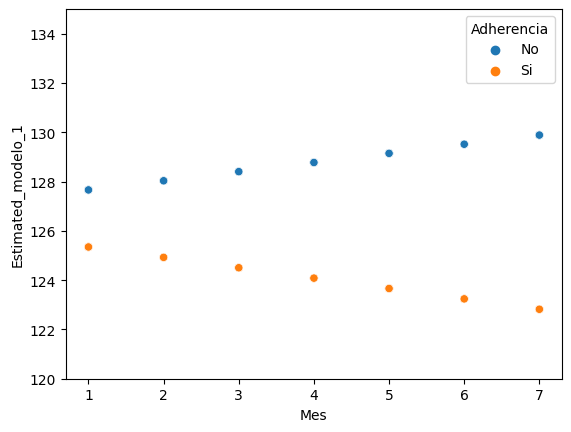

In [10]:
sample_df["Estimated_modelo_1"] = modelo_1.predict(sample_df[modelo_1_efectos])

sns.scatterplot(
    x=sample_df["Mes"],
    y=sample_df["Estimated_modelo_1"],
    hue=sample_df["Adherencia"].map({0: "No", 1: "Si"})
)
plt.ylim(YLIM)

In [11]:
with open("../Tesina/Mio/tables/modelo_1.tex", "w") as f:
    f.write(model_to_latex(modelo_1))

# Modelo 2

In [12]:
modelo_2_efectos = ["Intercept", "Sexo", "Edad", "Adherencia_Perfecta", "Mes", "Mes*Adherencia_Perfecta"]

In [13]:
modelo_2 = sm.MixedLM(
    endog=tesis["TAS"],
    exog=tesis[modelo_2_efectos],
    groups=tesis["idPaciente"],
    exog_re=tesis[["Intercept", "Mes"]]
).fit(reml=False)
print(modelo_2.summary())
round(modelo_2.aic, 2), round(modelo_2.bic, 2)

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     TAS        
No. Observations:     3920        Method:                 ML         
No. Groups:           560         Scale:                  115.2019   
Min. group size:      7           Log-Likelihood:         -15415.0824
Max. group size:      7           Converged:              Yes        
Mean group size:      7.0                                            
---------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept               121.926    2.376 51.320 0.000 117.269 126.582
Sexo                      3.801    0.740  5.133 0.000   2.350   5.252
Edad                      0.176    0.038  4.590 0.000   0.101   0.250
Adherencia_Perfecta      -2.491    1.176 -2.119 0.034  -4.796  -0.187
Mes                      -0.197    0

(30850.16, 30912.9)

(120.0, 135.0)

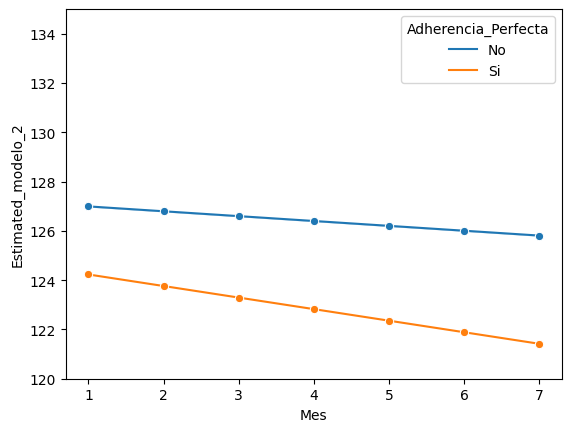

In [14]:
sample_df["Estimated_modelo_2"] = modelo_2.predict(sample_df[modelo_2_efectos])

sns.lineplot(
    x=sample_df["Mes"],
    y=sample_df["Estimated_modelo_2"],
    hue=sample_df["Adherencia_Perfecta"].map({0: "No", 1: "Si"}),
    marker="o"
)
plt.ylim(YLIM)

In [15]:
with open("../Tesina/Mio/tables/modelo_2.tex", "w") as f:
    f.write(model_to_latex(modelo_2))

# Modelo 3

In [16]:
modelo_3_efectos = ["Intercept", "Sexo", "Edad", "Adherencia_Total", "Mes", "Mes*Adherencia_Total"]

In [17]:
modelo_3 = sm.MixedLM(
    endog=tesis["TAS"],
    exog=tesis[modelo_3_efectos],
    groups=tesis["idPaciente"],
    exog_re=tesis[["Intercept", "Mes"]]
).fit(reml=False)
print(modelo_3.summary())
round(modelo_3.aic, 2), round(modelo_3.bic, 2)

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    TAS        
No. Observations:    3920       Method:                ML         
No. Groups:          560        Scale:                 115.2019   
Min. group size:     7          Log-Likelihood:        -15417.6594
Max. group size:     7          Converged:             Yes        
Mean group size:     7.0                                          
------------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            122.419    3.036 40.318 0.000 116.468 128.370
Sexo                   3.732    0.747  4.995 0.000   2.268   5.197
Edad                   0.172    0.039  4.469 0.000   0.097   0.248
Adherencia_Total      -1.828    2.483 -0.736 0.462  -6.695   3.039
Mes                    0.498    0.380  1.308 0.191  -0.248   1.243
Mes*Adhere

(30855.32, 30918.06)

(120.0, 135.0)

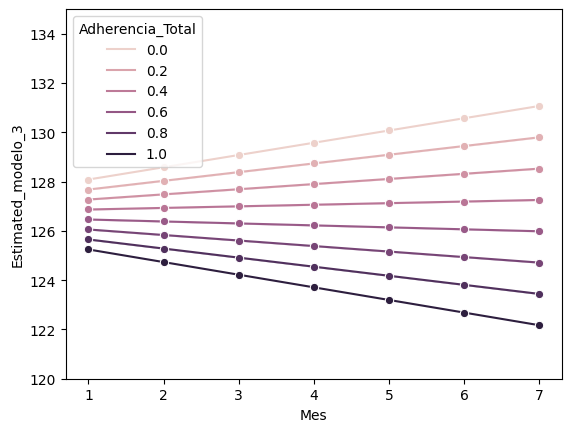

In [18]:
sample_df["Estimated_modelo_3"] = modelo_3.predict(sample_df[modelo_3_efectos])

sns.lineplot(
    x=sample_df["Mes"],
    y=sample_df["Estimated_modelo_3"],
    hue=sample_df["Adherencia_Total"],
    marker="o"
)
plt.ylim(YLIM)

In [19]:
with open("../Tesina/Mio/tables/modelo_3.tex", "w") as f:
    f.write(model_to_latex(modelo_3))

# Modelo 4

In [20]:
modelo_4_efectos = ["Intercept", "Sexo", "Edad", "Adherencia_lag1", "Mes", "Mes*Adherencia_lag1"]

In [21]:
modelo_4 = sm.MixedLM(
    endog=tesis["TAS"],
    exog=tesis[modelo_4_efectos],
    groups=tesis["idPaciente"],
    exog_re=tesis[["Intercept", "Mes"]]
).fit(reml=False)
print(modelo_4.summary())
round(modelo_4.aic, 2), round(modelo_4.bic, 2)

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   TAS        
No. Observations:     3920      Method:               ML         
No. Groups:           560       Scale:                115.2933   
Min. group size:      7         Log-Likelihood:       -15422.5016
Max. group size:      7         Converged:            Yes        
Mean group size:      7.0                                        
-----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           121.125    2.388 50.714 0.000 116.444 125.807
Sexo                  3.869    0.751  5.151 0.000   2.397   5.341
Edad                  0.162    0.039  4.197 0.000   0.087   0.238
Adherencia_lag1       0.189    0.815  0.232 0.817  -1.408   1.786
Mes                   0.064    0.179  0.359 0.720  -0.287   0.416
Mes*Adherencia_lag1  -0.

(30865.0, 30927.74)

(120.0, 135.0)

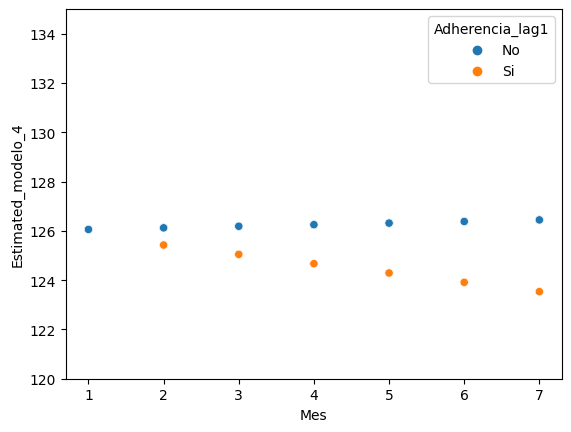

In [22]:
sample_df["Estimated_modelo_4"] = modelo_4.predict(sample_df[modelo_4_efectos])

sns.scatterplot(
    x=sample_df["Mes"],
    y=sample_df["Estimated_modelo_4"],
    hue=sample_df["Adherencia_lag1"].map({0: "No", 1: "Si"})
)
plt.ylim(YLIM)

In [23]:
with open("../Tesina/Mio/tables/modelo_4.tex", "w") as f:
    f.write(model_to_latex(modelo_4))

# Modelo 5

In [24]:
modelo_5_efectos = ["Intercept", "Sexo", "Edad", "Adherencia_Acumulada", "Mes", "Mes*Adherencia_Acumulada"]

In [25]:
modelo_5 = sm.MixedLM(
    endog=tesis["TAS"],
    exog=tesis[modelo_5_efectos],
    groups=tesis["idPaciente"],
    exog_re=tesis[["Intercept", "Mes"]]
).fit(reml=False)
print(modelo_5.summary())
round(modelo_5.aic, 2), round(modelo_5.bic, 2)

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     TAS        
No. Observations:      3920        Method:                 ML         
No. Groups:            560         Scale:                  114.2663   
Min. group size:       7           Log-Likelihood:         -15409.3836
Max. group size:       7           Converged:              Yes        
Mean group size:       7.0                                            
----------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept                123.107    2.586 47.603 0.000 118.038 128.175
Sexo                       3.721    0.749  4.966 0.000   2.253   5.190
Edad                       0.177    0.039  4.574 0.000   0.101   0.253
Adherencia_Acumulada      -3.247    1.421 -2.285 0.022  -6.033  -0.461
Mes                    

(30838.77, 30901.51)

(120.0, 135.0)

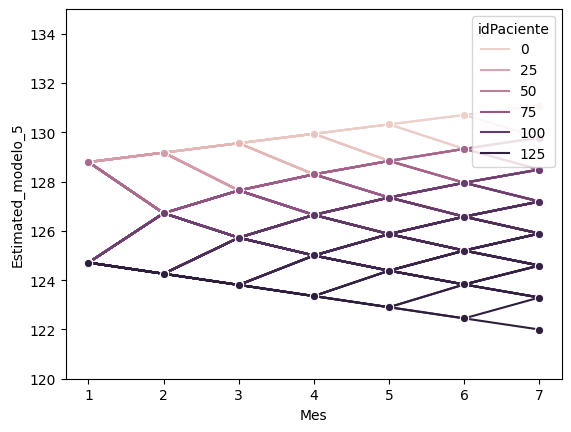

In [26]:
sample_df["Estimated_modelo_5"] = modelo_5.predict(sample_df[modelo_5_efectos])

sns.lineplot(
    x=sample_df["Mes"],
    y=sample_df["Estimated_modelo_5"],
    hue=sample_df["idPaciente"],
    marker="o"
)
plt.ylim(YLIM)

In [27]:
with open("../Tesina/Mio/tables/modelo_5.tex", "w") as f:
    f.write(model_to_latex(modelo_5))

# Modelo 6

In [28]:
modelo_6_efectos = ["Intercept", "Sexo", "Edad", "Adherencia", "Adherencia_Total", "Mes", "Mes*Adherencia", "Mes*Adherencia_Total"]

In [29]:
modelo_6 = sm.MixedLM(
    endog=tesis["TAS"],
    exog=tesis[modelo_6_efectos],
    groups=tesis["idPaciente"],
    exog_re=tesis[["Intercept", "Mes"]]
).fit(reml=False)
print(modelo_6.summary())
round(modelo_6.aic, 2), round(modelo_6.bic, 2)

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    TAS        
No. Observations:    3920       Method:                ML         
No. Groups:          560        Scale:                 113.2189   
Min. group size:     7          Log-Likelihood:        -15389.8304
Max. group size:     7          Converged:             Yes        
Mean group size:     7.0                                          
------------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            121.987    3.032 40.235 0.000 116.044 127.929
Sexo                   3.723    0.747  4.983 0.000   2.259   5.187
Edad                   0.171    0.039  4.429 0.000   0.095   0.246
Adherencia            -2.055    1.325 -1.550 0.121  -4.652   0.543
Adherencia_Total       0.662    2.784  0.238 0.812  -4.795   6.119
Mes       

(30803.66, 30878.95)

(120.0, 135.0)

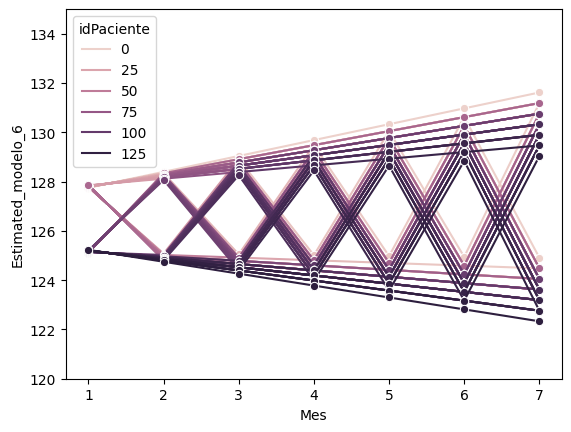

In [30]:
sample_df["Estimated_modelo_6"] = modelo_6.predict(sample_df[modelo_6_efectos])

sns.lineplot(
    x=sample_df["Mes"],
    y=sample_df["Estimated_modelo_6"],
    hue=sample_df["idPaciente"],
    marker="o"
)
plt.ylim(YLIM)

In [31]:
with open("../Tesina/Mio/tables/modelo_6.tex", "w") as f:
    f.write(model_to_latex(modelo_6))

# Experimental

In [32]:
modelo_experimental_efectos = ["Intercept", "Sexo", "Edad", "Mes", "Mes*Adherencia_Acumulada"]

In [33]:
modelo_experimental = sm.MixedLM(
    endog=tesis["TAS"],
    exog=tesis[modelo_experimental_efectos],
    groups=tesis["idPaciente"],
    exog_re=tesis[["Intercept", "Mes"]]
).fit(reml=False)
print(modelo_experimental.summary())
round(modelo_experimental.aic, 2), round(modelo_experimental.bic, 2)

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     TAS        
No. Observations:      3920        Method:                 ML         
No. Groups:            560         Scale:                  114.5704   
Min. group size:       7           Log-Likelihood:         -15412.0036
Max. group size:       7           Converged:              Yes        
Mean group size:       7.0                                            
----------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept                120.678    2.354 51.262 0.000 116.064 125.292
Sexo                       3.745    0.748  5.007 0.000   2.279   5.211
Edad                       0.174    0.039  4.522 0.000   0.099   0.250
Mes                        0.838    0.233  3.592 0.000   0.381   1.295
Mes*Adherencia_Acumulad

(30842.01, 30898.47)

(120.0, 135.0)

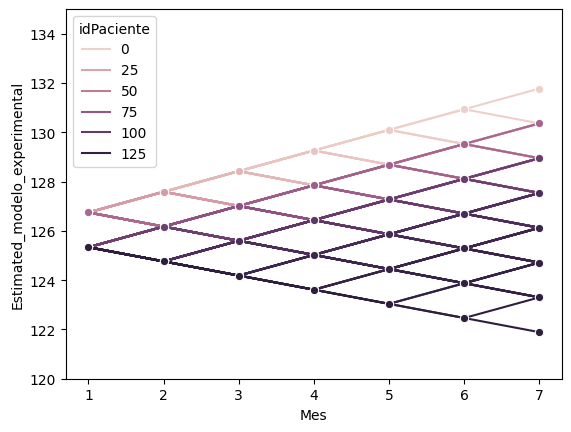

In [34]:
sample_df["Estimated_modelo_experimental"] = modelo_experimental.predict(sample_df[modelo_experimental_efectos])

sns.lineplot(
    x=sample_df["Mes"],
    y=sample_df["Estimated_modelo_experimental"],
    hue=sample_df["idPaciente"],
    marker="o"
)
plt.ylim(YLIM)